In [11]:
!pip install torch_geometric

Defaulting to user installation because normal site-packages is not writeable


In [3]:
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from sklearn.neighbors import kneighbors_graph
import numpy as np
from torch_geometric.data import Data
from scipy.sparse import coo_matrix
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GCNConv, GAE
from torch_geometric.utils import train_test_split_edges
from sklearn.manifold import TSNE
import tracemalloc
import time
from utils import *
from metrics import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Function to measure GPU memory usage
def get_gpu_memory():
    return torch.cuda.memory_allocated() / (1024 * 1024)  # Convert to MB


# Main function to execute the steps
def get_amazon_graph():
    dataset = Planetoid(root='.', name='Cora', transform=NormalizeFeatures())
    data = dataset[0]
    data.num_classes = dataset.num_classes
    data.num_node_features = dataset.num_node_features


    # Print the Data object to verify
    print(data)



    return data

In [4]:
data = get_amazon_graph()

X = data.x.numpy()

# local_metrics = LocalMetric()

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], num_classes=7, num_node_features=1433)


Training GAE model...
Epoch: 10, Loss: 1.3635165691375732
Epoch: 20, Loss: 1.3300801515579224
Epoch: 30, Loss: 1.2968255281448364
Epoch: 40, Loss: 1.2276103496551514
Epoch: 50, Loss: 1.1626300811767578
Epoch: 60, Loss: 1.1347980499267578
Epoch: 70, Loss: 1.114452838897705
Epoch: 80, Loss: 1.097046971321106
Epoch: 90, Loss: 1.0977814197540283
Epoch: 100, Loss: 1.0909414291381836
Epoch: 110, Loss: 1.0812623500823975
Epoch: 120, Loss: 1.0872793197631836
Epoch: 130, Loss: 1.086906909942627
Epoch: 140, Loss: 1.0820972919464111
Epoch: 150, Loss: 1.0761260986328125
Epoch: 160, Loss: 1.085540533065796
Epoch: 170, Loss: 1.0769598484039307
Epoch: 180, Loss: 1.0887503623962402
Epoch: 190, Loss: 1.0772910118103027
Epoch: 200, Loss: 1.088032603263855
Epoch: 210, Loss: 1.0676696300506592
Epoch: 220, Loss: 1.0596996545791626
Epoch: 230, Loss: 1.060957908630371
Epoch: 240, Loss: 1.059145212173462
Epoch: 250, Loss: 1.0494028329849243
Epoch: 260, Loss: 1.0360100269317627
Epoch: 270, Loss: 1.014661431312

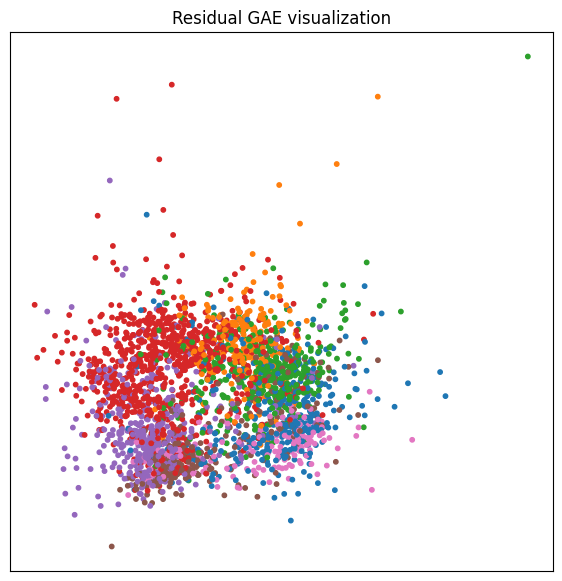

In [32]:
# dataset = Planetoid(root='.', name='Cora', transform=NormalizeFeatures())
# data = dataset[0]
# data.train_mask = data.val_mask = data.test_mask = data.y = None  # Ensure these are not used by train_test_split_edges
data = train_test_split_edges(data)

class ResidualGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(ResidualGCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)
        # Residual connection from input to output
        self.shortcut = torch.nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        identity = x

        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))

        if x.size(-1) != identity.size(-1):
            identity = self.shortcut(identity)

        x = self.conv3(x, edge_index)

        x += identity  # Add the input to the output
        return x


class GNNNodeClassifier(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GNNNodeClassifier, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels, cached=True)
        self.conv2 = GCNConv(hidden_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Parameters
out_channels_AE = 2
num_features = data.num_node_features
num_classes = data.num_classes
epochs_AE = 300
hidden_channels_AE = 16

# Model initialization
model = GAE(ResidualGCNEncoder(num_features, hidden_channels_AE, out_channels_AE)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

GAE_loss_history = []

# Training the GAE model with metrics measurement
print("Training GAE model...")
tracemalloc.start()
start_time = time.time()
start_gpu_memory = get_gpu_memory()

for epoch in range(1, epochs_AE + 1):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    GAE_loss_history.append(loss.item())
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

end_time = time.time()
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()
end_gpu_memory = get_gpu_memory()

# Calculate and print metrics
time_taken = end_time - start_time
ram_used = (current - peak) / 1024 / 1024  # Convert to MB
gpu_used = end_gpu_memory - start_gpu_memory

print(f"GAE Training Time: {time_taken:.2f} seconds")
print(f"GAE Training RAM Memory usage: Current={current / 1024 / 1024:.2f}MB, Peak={peak / 1024 / 1024:.2f}MB")
print(f"GAE Training GPU Memory usage: {gpu_used:.2f}MB")


# Update data.x with the encoded features for classification
encoded_features = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach()
data.x = encoded_features
hidden_channels_GNN = 16

# Initialize the GNN model for node classification
gnn_model = GNNNodeClassifier(out_channels_AE, hidden_channels_GNN, num_classes).to(device)
optimizer_gnn = torch.optim.Adam(gnn_model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Reconstruct full edge_index from the split edges for training the GNN
full_edge_index = torch.cat([data.train_pos_edge_index, data.val_pos_edge_index, data.test_pos_edge_index], dim=-1).to(device)

GNN_loss_history = []

# Training the GNN model
for epoch in range(300):
    gnn_model.train()
    optimizer_gnn.zero_grad()
    out = gnn_model(data.x, full_edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask].to(device))
    loss.backward()
    optimizer_gnn.step()
    GNN_loss_history.append(loss.item())
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

fig, ax = plt.subplots(figsize=(7, 7))
plot_no_show(ax, encoded_features.cpu().detach().numpy(), pure_labels, 'Residual GAE visualization', size=10, sample=False)
plt.show()

In [15]:
gnn_model.eval()
with torch.no_grad():
    out = gnn_model(data.x, full_edge_index)
    preds = out.argmax(dim=1)
    labels = data.y
    mask = data.test_mask
    test_preds = preds[mask].cpu().numpy()
    test_labels = labels[mask].cpu().numpy()

    accuracy = accuracy_score(test_labels, test_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(test_labels, test_preds, average='macro')

print(f"GNN accuracy: {accuracy:.4f}, GNN precision: {precision:.4f}, GNN recall: {recall:.4f}, GNN F1 score: {f1:.4f}")



GNN accuracy: 0.5440, GNN precision: 0.4865, GNN recall: 0.5116, GNN F1 score: 0.4915


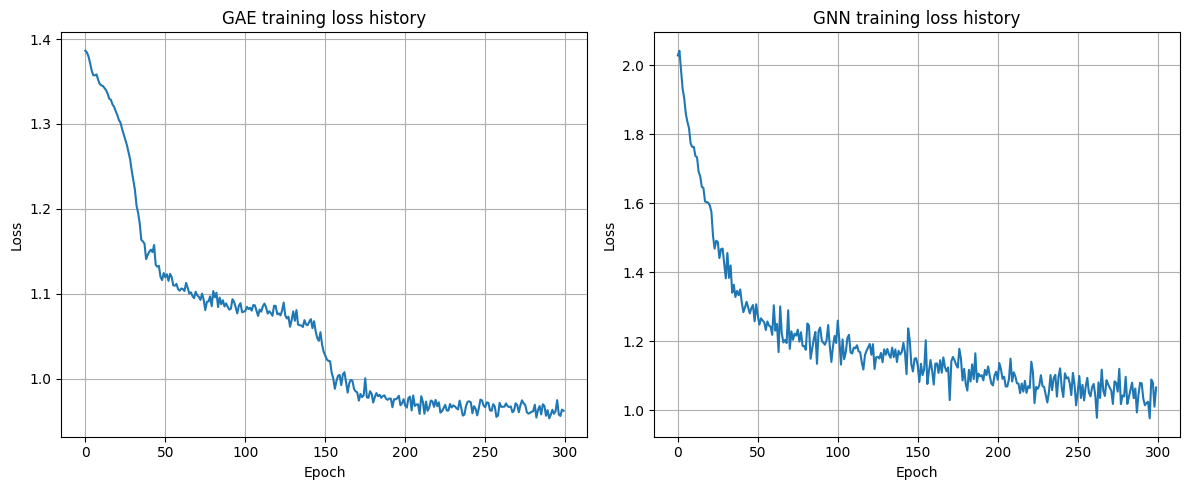

In [16]:
plt.figure(figsize=(12, 5))

# GAE training loss history
plt.subplot(1, 2, 1)
plt.plot(GAE_loss_history, label='GAE training loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GAE training loss history')
plt.grid(True)  # Assuming you want to always display the grid


# GNN training loss history
plt.subplot(1, 2, 2)
plt.plot(GNN_loss_history, label='GNN training loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GNN training loss history')
plt.grid(True)  # Assuming you want to always display the grid


plt.tight_layout()
plt.show()

In [ ]:
pure_data = get_amazon_graph()
pure_X = pure_data.x.cpu().detach().numpy()
pure_labels = pure_data.y.cpu().numpy()

GAE_variant = "residual"
dataset_name = "Cora"
algorithm_name = "GAE"
local_metrics.calculate_knn_gain_and_dr_quality(
    X_lds=encoded_features.cpu().detach().numpy(),
    X_hds=pure_X,
    labels=pure_labels,
    method_name="{} {}".format(f"{dataset_name}", f"{algorithm_name}-{GAE_variant}"))



# visualise(encoded_features.cpu().detach().numpy(), pure_labels, 'Residual GAE visualization', size=10)

# 2. Residual GAE + tSNE

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], num_classes=7, num_node_features=1433)


/home/asemerjak/.local/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Training GAE model...
Epoch: 10, Loss: 1.3822472095489502
Epoch: 20, Loss: 1.3645223379135132
Epoch: 30, Loss: 1.3514759540557861
Epoch: 40, Loss: 1.3360350131988525
Epoch: 50, Loss: 1.319307565689087
Epoch: 60, Loss: 1.2964682579040527
Epoch: 70, Loss: 1.267629623413086
Epoch: 80, Loss: 1.2049384117126465
Epoch: 90, Loss: 1.1575080156326294
Epoch: 100, Loss: 1.14448082447052
Epoch: 110, Loss: 1.1199707984924316
Epoch: 120, Loss: 1.1019287109375
Epoch: 130, Loss: 1.1071704626083374
Epoch: 140, Loss: 1.09425950050354
Epoch: 150, Loss: 1.0970665216445923
Epoch: 160, Loss: 1.0947340726852417
Epoch: 170, Loss: 1.0868664979934692
Epoch: 180, Loss: 1.0967987775802612
Epoch: 190, Loss: 1.0763856172561646
Epoch: 200, Loss: 1.0785084962844849
Epoch: 210, Loss: 1.0774825811386108
Epoch: 220, Loss: 1.0779920816421509
Epoch: 230, Loss: 1.0512216091156006
Epoch: 240, Loss: 1.0540006160736084
Epoch: 250, Loss: 1.0530297756195068
Epoch: 260, Loss: 1.0279401540756226
Epoch: 270, Loss: 1.00720798969268

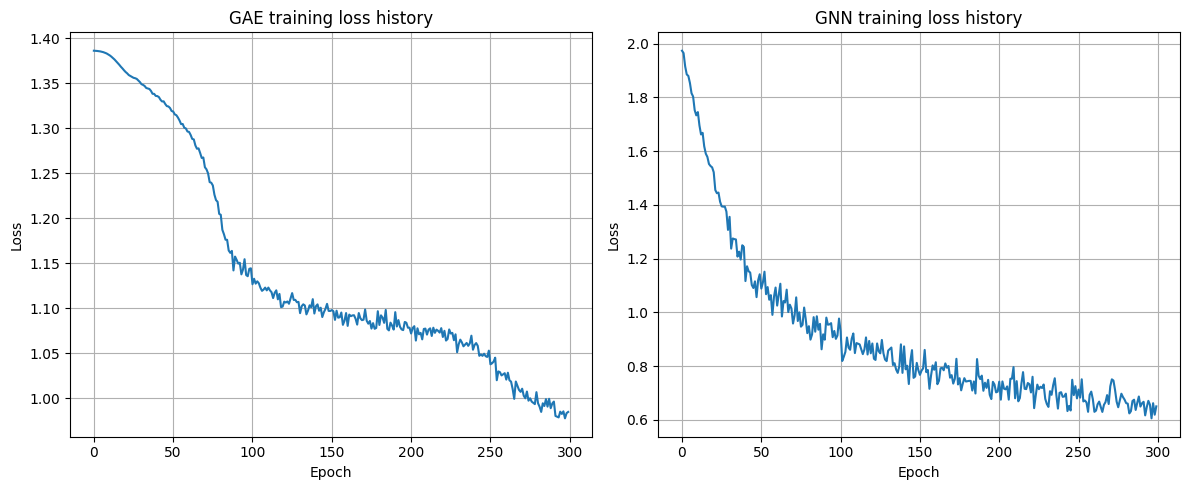

In [18]:
data = get_amazon_graph()

# dataset = Planetoid(root='.', name='Cora', transform=NormalizeFeatures())
# data = dataset[0]
# data.train_mask = data.val_mask = data.test_mask = data.y = None  # Ensure these are not used by train_test_split_edges

data = train_test_split_edges(data)

# Parameters
out_channels_AE = 16
num_features = data.num_features
num_classes = data.num_classes
epochs_AE = 300
hidden_channels_AE = 32

# Model initialization
model = GAE(ResidualGCNEncoder(num_features, hidden_channels_AE, out_channels_AE)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

GAE_loss_history = []

# Training the GAE model with metrics measurement
print("Training GAE model...")
tracemalloc.start()
start_time = time.time()
start_gpu_memory = get_gpu_memory()

for epoch in range(1, epochs_AE + 1):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    GAE_loss_history.append(loss.item())
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

end_time = time.time()
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()
end_gpu_memory = get_gpu_memory()

# Calculate and print metrics
time_taken = end_time - start_time
ram_used = (current - peak) / 1024 / 1024  # Convert to MB
gpu_used = end_gpu_memory - start_gpu_memory

print(f"GAE Training Time: {time_taken:.2f} seconds")
print(f"GAE Training RAM Memory usage: Current={current / 1024 / 1024:.2f}MB, Peak={peak / 1024 / 1024:.2f}MB")
print(f"GAE Training GPU Memory usage: {gpu_used:.2f}MB")

# Update data.x with the encoded features for classification
encoded_features = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach()
data.x = encoded_features
hidden_channels_GNN = 16

# Initialize the GNN model for node classification
gnn_model = GNNNodeClassifier(out_channels_AE, hidden_channels_GNN, num_classes).to(device)
optimizer_gnn = torch.optim.Adam(gnn_model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Reconstruct full edge_index from the split edges for training the GNN
full_edge_index = torch.cat([data.train_pos_edge_index, data.val_pos_edge_index, data.test_pos_edge_index], dim=-1).to(device)

GNN_loss_history = []

# Training the GNN model
for epoch in range(300):
    gnn_model.train()
    optimizer_gnn.zero_grad()
    out = gnn_model(data.x, full_edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask].to(device))
    loss.backward()
    optimizer_gnn.step()
    GNN_loss_history.append(loss.item())
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

gnn_model.eval()
with torch.no_grad():
    out = gnn_model(data.x, full_edge_index)
    preds = out.argmax(dim=1)
    labels = data.y
    mask = data.test_mask
    test_preds = preds[mask].cpu().numpy()
    test_labels = labels[mask].cpu().numpy()

    accuracy = accuracy_score(test_labels, test_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(test_labels, test_preds, average='macro')

print(f"GNN accuracy: {accuracy:.4f}, GNN precision: {precision:.4f}, GNN recall: {recall:.4f}, GNN F1 score: {f1:.4f}")


plt.figure(figsize=(12, 5))

# GAE training loss history
plt.subplot(1, 2, 1)
plt.plot(GAE_loss_history, label='GAE training loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GAE training loss history')
plt.grid(True)  # Assuming you want to always display the grid


# GNN training loss history
plt.subplot(1, 2, 2)
plt.plot(GNN_loss_history, label='GNN training loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GNN training loss history')
plt.grid(True)  # Assuming you want to always display the grid


plt.tight_layout()
plt.show()




Performing t-SNE transformation...
t-SNE Transformation Time: 19.76 seconds
t-SNE Transformation RAM Memory usage: Current=0.03MB, Peak=87.82MB
t-SNE Transformation GPU Memory usage: 0.00MB
Calculating d_hd
Amazon GAE-residual + t-SNE


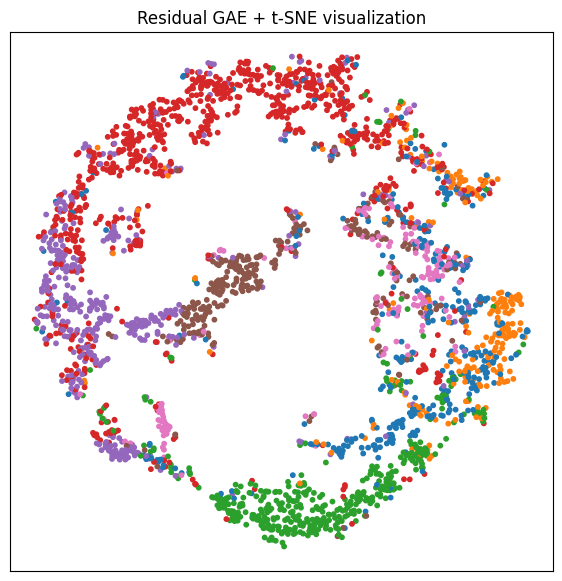

In [25]:
tsne = TSNE(n_components=2, random_state=0, metric='cosine')

# Perform t-SNE transformation with metrics measurement
print("Performing t-SNE transformation...")
tracemalloc.start()
start_time = time.time()
start_gpu_memory = get_gpu_memory()

tsne_results = tsne.fit_transform(encoded_features.cpu().detach().numpy())

end_time = time.time()
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()
end_gpu_memory = get_gpu_memory()

# Calculate and print metrics
time_taken = end_time - start_time
ram_used = (current - peak) / 1024 / 1024  # Convert to MB
gpu_used = end_gpu_memory - start_gpu_memory

print(f"t-SNE Transformation Time: {time_taken:.2f} seconds")
print(f"t-SNE Transformation RAM Memory usage: Current={current / 1024 / 1024:.2f}MB, Peak={peak / 1024 / 1024:.2f}MB")
print(f"t-SNE Transformation GPU Memory usage: {gpu_used:.2f}MB")

pure_labels = pure_data.y.cpu().numpy()

GAE_variant = "residual + t-SNE"
dataset_name = "Amazon"
algorithm_name = "GAE"
local_metrics.calculate_knn_gain_and_dr_quality(
    X_lds=tsne_results,
    X_hds=pure_X,
    labels=pure_labels,
    method_name="{} {}".format(f"{dataset_name}", f"{algorithm_name}-{GAE_variant}"))

fig, ax = plt.subplots(figsize=(7, 7))
plot_no_show(ax, tsne_results, pure_labels, 'Residual GAE + t-SNE visualization', size=10, sample=False)
plt.show()

# 3. pure t-SNE

Performing t-SNE transformation...
t-SNE Transformation Time: 19.35 seconds
t-SNE Transformation RAM Memory usage: Current=0.04MB, Peak=87.83MB
t-SNE Transformation GPU Memory usage: 0.00MB
Calculating d_hd
Cora t-SNE


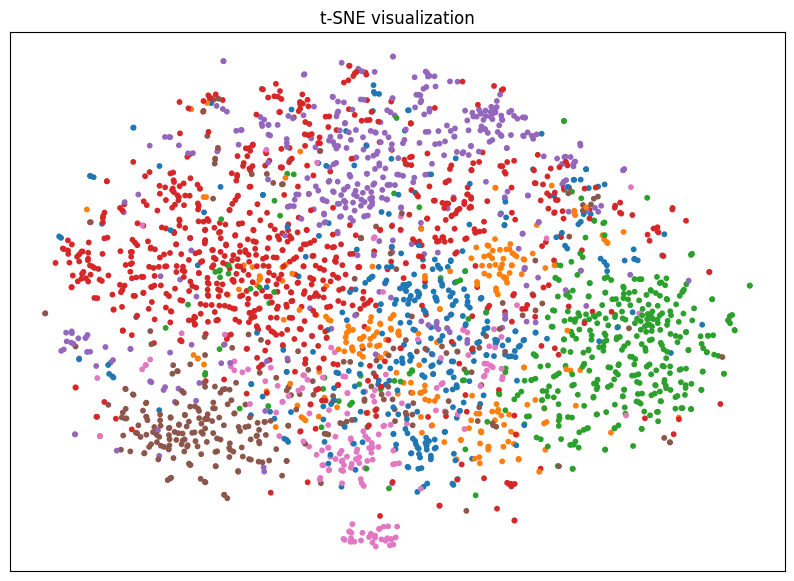

In [20]:
tsne = TSNE(n_components=2, random_state=0, metric='cosine')
# Perform t-SNE transformation with metrics measurement
print("Performing t-SNE transformation...")
tracemalloc.start()
start_time = time.time()
start_gpu_memory = get_gpu_memory()

tsne_results = tsne.fit_transform(pure_X)

end_time = time.time()
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()
end_gpu_memory = get_gpu_memory()

# Calculate and print metrics
time_taken = end_time - start_time
ram_used = (current - peak) / 1024 / 1024  # Convert to MB
gpu_used = end_gpu_memory - start_gpu_memory

print(f"t-SNE Transformation Time: {time_taken:.2f} seconds")
print(f"t-SNE Transformation RAM Memory usage: Current={current / 1024 / 1024:.2f}MB, Peak={peak / 1024 / 1024:.2f}MB")
print(f"t-SNE Transformation GPU Memory usage: {gpu_used:.2f}MB")


GAE_variant = "t-SNE"
dataset_name = "Cora"
algorithm_name = ""
local_metrics.calculate_knn_gain_and_dr_quality(
    X_lds=tsne_results,
    X_hds=pure_X,
    labels=pure_labels,
    method_name="{} {}".format(f"{dataset_name}", f"{algorithm_name}{GAE_variant}"))

visualise(tsne_results, pure_labels, 't-SNE visualization', size=10)


Finished.


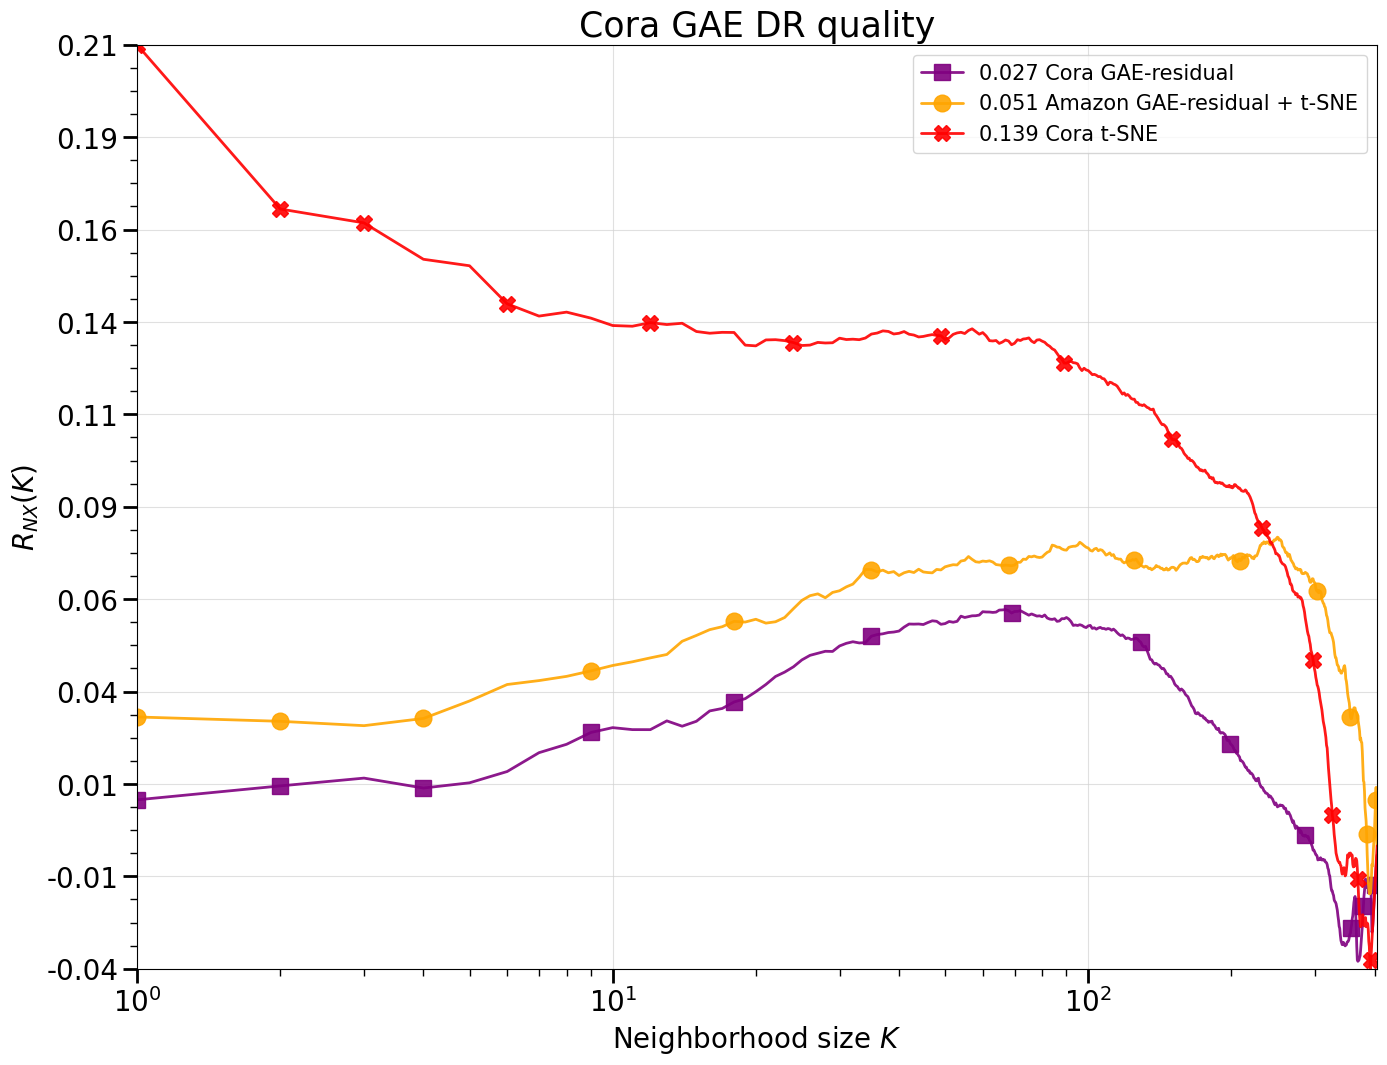

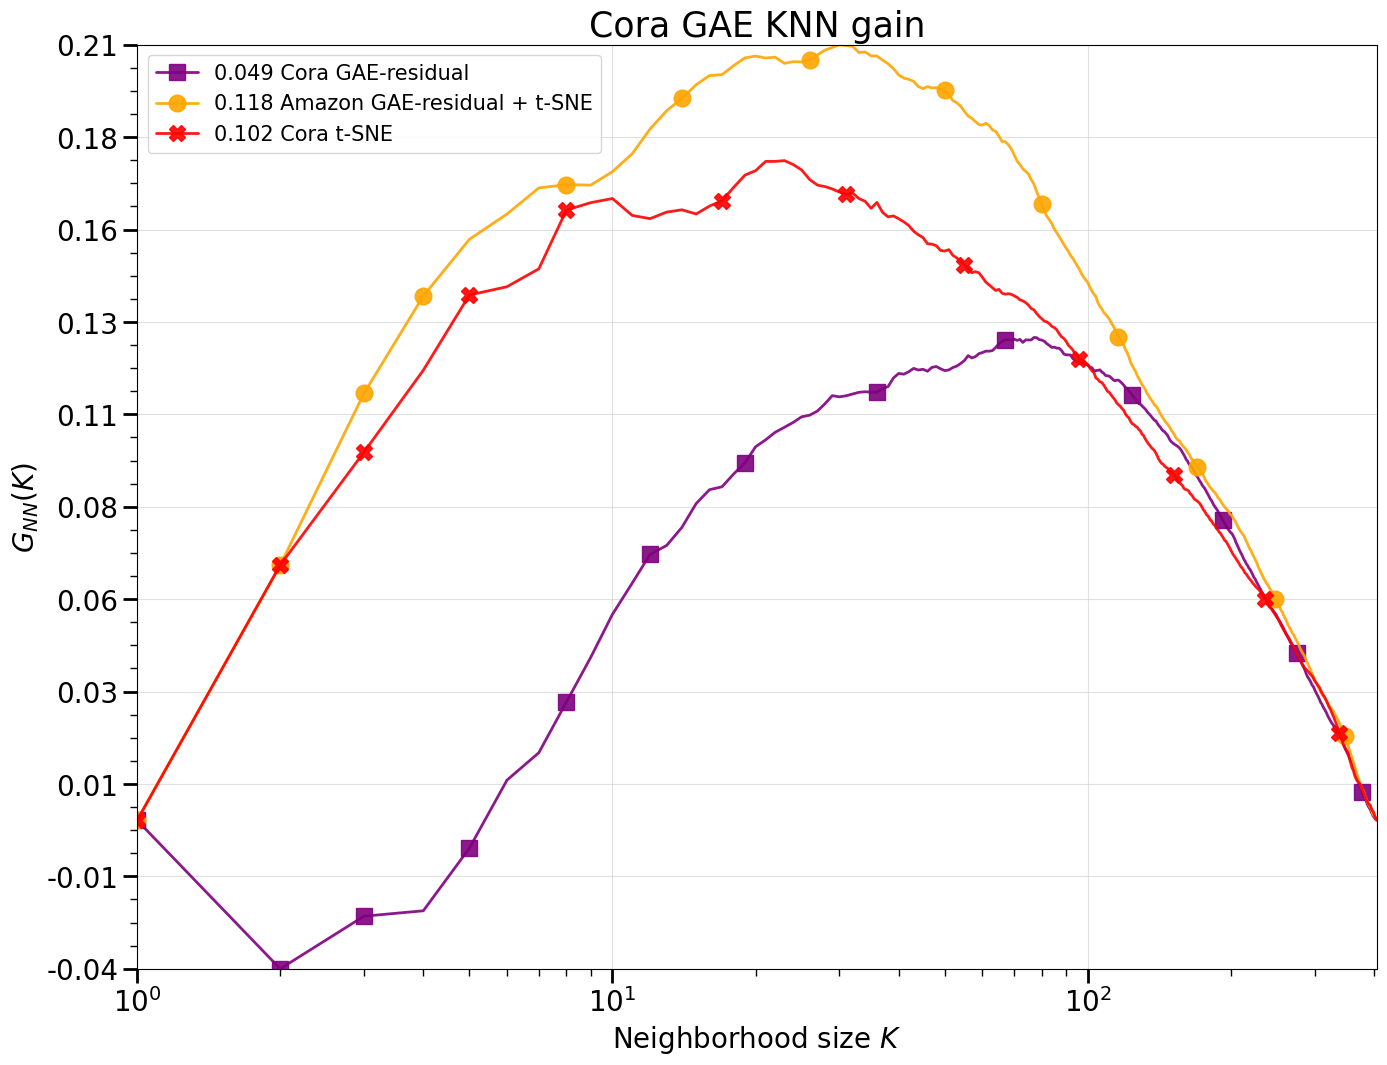

In [21]:
local_metrics.visualize(f"Cora GAE")

# 4. Residual GAE + UMAP & PaCMAP

In [13]:
class ResidualGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(ResidualGCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)
        # Residual connection from input to output
        self.shortcut = torch.nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        identity = x

        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))

        if x.size(-1) != identity.size(-1):
            identity = self.shortcut(identity)

        x = self.conv3(x, edge_index)

        x += identity  # Add the input to the output
        return x


data = get_amazon_graph()
data = train_test_split_edges(data)

# Parameters
out_channels_AE = 16
num_features = data.num_features
num_classes = data.num_classes
epochs_AE = 300
hidden_channels_AE = 32

# Model initialization
model = GAE(ResidualGCNEncoder(num_features, hidden_channels_AE, out_channels_AE)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

GAE_loss_history = []

# Training the GAE model with metrics measurement
print("Training GAE model...")


for epoch in range(1, epochs_AE + 1):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    GAE_loss_history.append(loss.item())
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')


# Update data.x with the encoded features for classification
encoded_features = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach()

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], num_classes=7, num_node_features=1433)


/home/asemerjak/.local/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Training GAE model...
Epoch: 10, Loss: 1.381880283355713
Epoch: 20, Loss: 1.3647470474243164
Epoch: 30, Loss: 1.3475005626678467
Epoch: 40, Loss: 1.327418565750122
Epoch: 50, Loss: 1.3014277219772339
Epoch: 60, Loss: 1.259718894958496
Epoch: 70, Loss: 1.2048982381820679
Epoch: 80, Loss: 1.1580065488815308
Epoch: 90, Loss: 1.1322696208953857
Epoch: 100, Loss: 1.1252343654632568
Epoch: 110, Loss: 1.1128113269805908
Epoch: 120, Loss: 1.1052141189575195
Epoch: 130, Loss: 1.1080400943756104
Epoch: 140, Loss: 1.092818021774292
Epoch: 150, Loss: 1.0936095714569092
Epoch: 160, Loss: 1.0959384441375732
Epoch: 170, Loss: 1.0916812419891357
Epoch: 180, Loss: 1.073691487312317
Epoch: 190, Loss: 1.0647811889648438
Epoch: 200, Loss: 1.0296305418014526
Epoch: 210, Loss: 1.0290565490722656
Epoch: 220, Loss: 1.0087487697601318
Epoch: 230, Loss: 0.995856761932373
Epoch: 240, Loss: 1.0056428909301758
Epoch: 250, Loss: 0.9978768825531006
Epoch: 260, Loss: 0.9918667078018188
Epoch: 270, Loss: 0.99907255172

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], num_classes=7, num_node_features=1433)
Performing UMAP transformation...


/home/asemerjak/.local/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


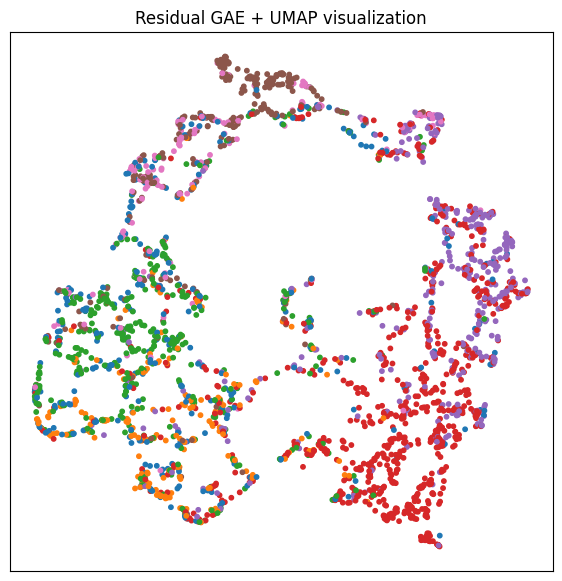

/home/asemerjak/.local/lib/python3.10/site-packages/pacmap/pacmap.py:828: UserWarning: Warning: random state is set to 0
  warnings.warn(f'Warning: random state is set to {_RANDOM_STATE}')


Performing PaCMAP transformation...


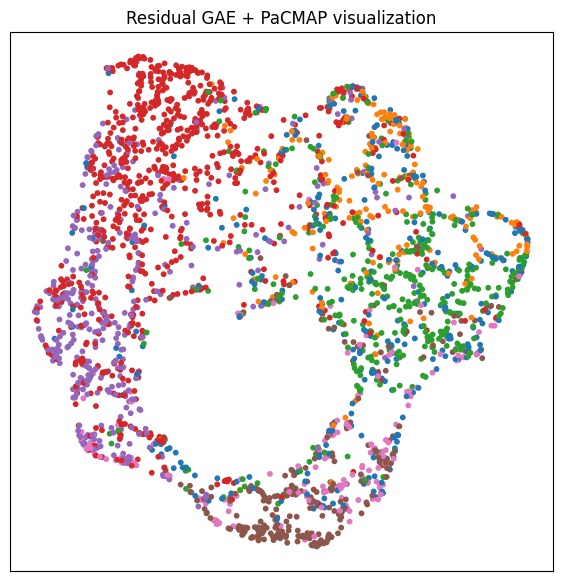

In [14]:
from umap import UMAP
from pacmap import PaCMAP

pure_data = get_amazon_graph()
pure_X = pure_data.x.cpu().detach().numpy()
pure_labels = pure_data.y.cpu().numpy()

umap = UMAP(n_components=2, random_state=0)

print("Performing UMAP transformation...")

umap_results = umap.fit_transform(encoded_features.cpu().detach().numpy())




fig, ax = plt.subplots(figsize=(7, 7))
plot_no_show(ax, umap_results, pure_labels, 'Residual GAE + UMAP visualization', size=10, sample=False)
plt.show()

pacmap = PaCMAP(n_components=2, random_state=0)

print("Performing PaCMAP transformation...")

pacmap_results = pacmap.fit_transform(encoded_features.cpu().detach().numpy())



fig, ax = plt.subplots(figsize=(7, 7))
plot_no_show(ax, pacmap_results, pure_labels, 'Residual GAE + PaCMAP visualization', size=10, sample=False)
plt.show()